# 机器学习练习 5 - 偏差和方差

这次练习的主要内容为偏差和方差，训练集&验证集&测试集

##  正则化线性回归
首先，我们需要先对一个水库的流出水量以及水库水位进行正则化线性归回。然后根据这个例子探讨方差-偏差的问题

In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_data(): 
    # 读取数据，其中： d['X'].shape = (12,1) 返回ravel后的结果，便于pandas处理
    d = sio.loadmat('ex5data1.mat')
    return map( np.ravel , [ d['X'] , d['y'] , d['Xval'] , d['yval'], d['Xtest'] , d['ytest'] ] )

In [3]:
X , y , Xval , yval , Xtest , ytest =load_data()

数据可视化

/Users/chenchangming/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


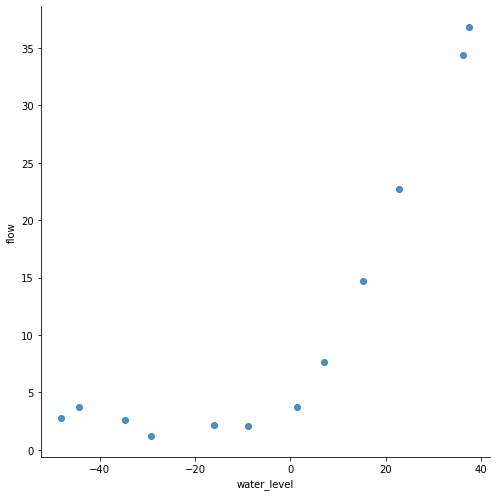

In [4]:
df = pd.DataFrame( {'water_level':X,'flow':y} )
sns.lmplot('water_level' , 'flow' , data=df , fit_reg=False , size=7)
plt.show()

In [5]:
X , Xval , Xtest = [ np.insert(x.reshape(x.shape[0],1),0,np.ones(x.shape[0]),axis=1) for x in (X , Xval , Xtest) ]
# 数据预处理 插入一列1   

# 代价函数
<img style="float: left;" src="../img/linear_cost.png">

In [6]:
def cost(theta , X , y): 
    """
    X.shape m*n 
    y.shapr m*1
    theta.shape n*1
    """
    
    m = X.shape[0]
    
    inner = X @ theta - y
    
    square_sum = inner.T @ inner  # (1,m)*(m,1) -> (1,1)
    cost = square_sum / (2*m)
    
    return cost


In [7]:
theta = np.ones(X.shape[1])
cost(theta , X , y)


303.9515255535976

# 梯度
<img style="float: left;" src="../img/linear_gradient.png">

In [8]:
def gradient (theta , X , y): 
    m = X.shape[0]
    inner = X.T @ (X @ theta.T - y)
    #  X: (m,n)     X.T: (n,m) 
    # (n,m)*(m.1)->(n,1)
    return inner / m

In [9]:
gradient(theta , X , y)

array([-15.30301567, 598.16741084])

还是建议  对于每一处比较复杂的矩阵乘法运算，自己计算一下维度

# 正则化梯度
<img style="float: left;" src="../img/linear_reg_gradient.png">

In [10]:
def regularized_gradient(theta , X ,y , l=1): 
    m = X.shape[0]
    
    regularized_term = theta.copy()
    regularized_term[0] = 0 # 不考虑thera0 的正则化代价
    # 这样也方便下面直接求 正则化梯度
    regularized_term = (l/m) * regularized_term
    
    return gradient(theta , X , y) + regularized_term

In [11]:
regularized_gradient(theta , X , y )

array([-15.30301567, 598.25074417])

# 拟合数据
> 暂定正则化项 $\lambda=0$

In [12]:
def regularized_cost(theta , X , y ,l=1): 
    m = X.shape[0]
    
    regularized_term = (1/(2*m)) * np.power(theta[1:],2).sum()

    return cost(theta , X , y ) + regularized_term

In [13]:
def linear_regression_np( X , y , l=1): 
    # 利用工具库函数  最小化代价函数
    """
    X (m,n+1)  插入了一列1
    y (m,1)
    l lambda 正则化用到的超参数
    
    函数返回训练的结果
    """
    
    theta = np.ones(X.shape[1])
    
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X , y ,l), 
                       method='TNC' , 
                       jac=regularized_gradient , 
                       options={'disp':True}
                      )
    
    return res

In [14]:
theta = np.ones(X.shape[0])
final_theta = linear_regression_np(X , y , l=0)


核对一下维度

In [15]:
theta.shape , X.shape , y.shape , final_theta['x']

((12,), (12, 2), (12,), array([13.08790362,  0.36777923]))

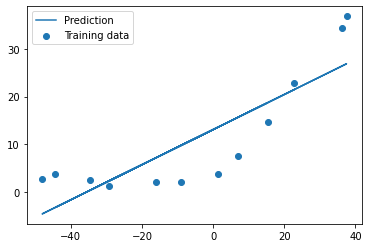

In [16]:
b = final_theta['x'][0] # b,m  是获得训练得到的两个参数，可理解为截距和斜率 
m = final_theta['x'][1]

# 根据结果做图
plt.scatter( X[:,1] , y , label = 'Training data' )
plt.plot(X[:,1] , X[:,1] *m + b , label = 'Prediction')
plt.legend(loc=2)
plt.show()

In [17]:
training_cost , cv_cost = [] , []


1.使用训练集的子集来拟合应模型

2.在计算训练代价和交叉验证代价时，没有用正则化

3.记住使用相同的训练集子集来计算训练代价

计算使用不同大小的训练集会有怎样的训练集代价和验证集代价

In [18]:
m = X.shape[0]
for i in range(1,m+1): 
    res = linear_regression_np(X[:i,:],y[:i],l=0)
    tc = regularized_cost(res.x , X[:i,:], y[:i], l=0)
    cv = regularized_cost(res.x , Xval , yval , l=0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

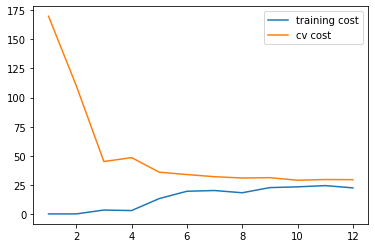

In [19]:

plt.plot(np.arange(1,m+1),training_cost , label = 'training cost')
plt.plot( np.arange(1,m+1), cv_cost , label = 'cv cost' )          
plt.legend(loc = 1)
plt.show()


 **欠拟合了**(在训练集和验证集上表现均不佳)

# 创建多项式特征

In [20]:
def normalize_feature(df): # 数据预处理
    return df.apply( lambda column: (column-column.mean())/column.std() )
    

In [21]:
def poly_features(x , power , as_ndarray=False): 
    data = { 'f{}'.format(i): np.power(x,i) for i in range(1,power+1) }
    df = pd.DataFrame(data)
    
    return df.values if as_ndarray else df
    
    

In [22]:
X, y, Xval, yval, Xtest, ytest = load_data()
X.shape

(12,)

In [23]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


In [32]:
def prepare_ploy_data ( *args , power ):
    
    
    def prepare(x): # 用于批量处理数据
        
        # 创建特征
        df = poly_features(x,power=power)
        
        # 归一化
        ndarr = normalize_feature(df).values
        
        # 添加 截距项（1）
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
       
    
    return ([prepare(x) for x in args])


# 准备多项式回归数据
1. 扩展特征到 8阶,或者你需要的阶数
2. 使用 **归一化** 来合并 $x^n$ 
3. don't forget intercept term

In [33]:
X_ploy , Xval_ploy , Xtest_poly = prepare_ploy_data(X , Xval , Xtest , power=8)
X_ploy[:3,:]


array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

# 画出学习曲线
> 首先，我们没有使用正则化，所以 $\lambda=0$ 

In [34]:

def plot_learning_curve(X, Xinit, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        # 正则化用于你和参数   在真正计算最后结果代价是是不考虑正则化代价的
        res = linear_regression_np(X[:i, :], y[:i], l=l)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    fig, ax = plt.subplots(2,  1, figsize=(12, 12))
    ax[0].plot(np.arange(1, m + 1), training_cost, label='training cost')
    ax[0].plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    ax[0].legend()

    fitx = np.linspace(-50, 50, 100) 
    fitxtmp = prepare_poly_data(fitx, power=8)
    fity = np.dot(prepare_poly_data(fitx, power=8)[0], linear_regression_np(X, y, l).x.T)
    
    ax[1].plot(fitx, fity, c='r', label='fitcurve')
    ax[1].scatter(Xinit, y, c='b', label='initial_Xy')
    
    ax[1].set_xlabel('water_level')
    ax[1].set_ylabel('flow')


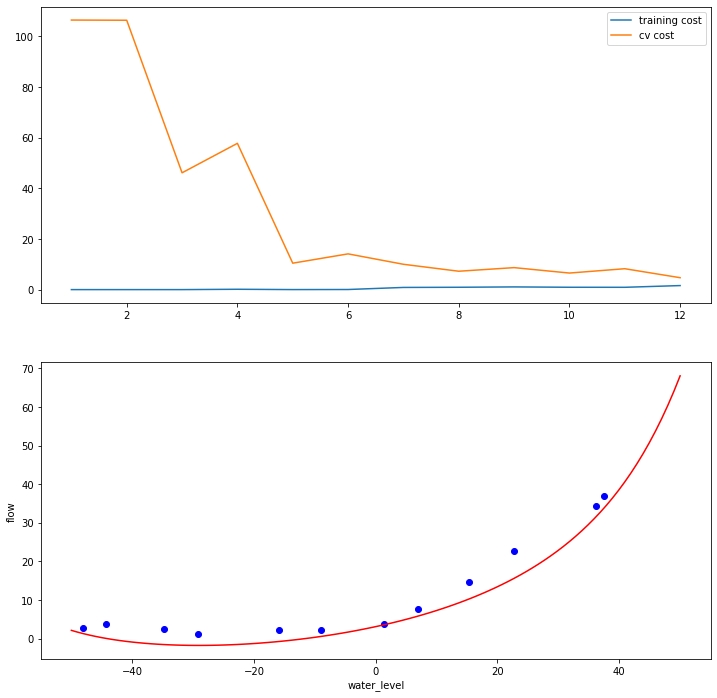

In [35]:
plot_learning_curve(X_ploy , X , y , Xval_ploy , yval , l=0)
plt.show()

##  调整正则化系数λ

令 $\lambda=1$

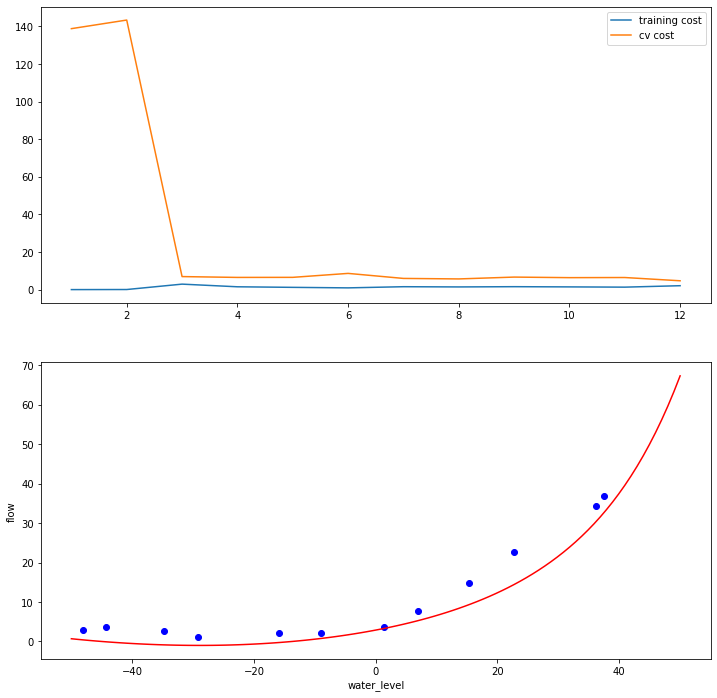

In [36]:
plot_learning_curve(X_ploy , X , y , Xval_ploy , yval , l=1)
plt.show()

训练代价不再是0了，也就是说我们减轻了**过拟合**(训练集误差小，验证集误差大)

令 $\lambda=100$

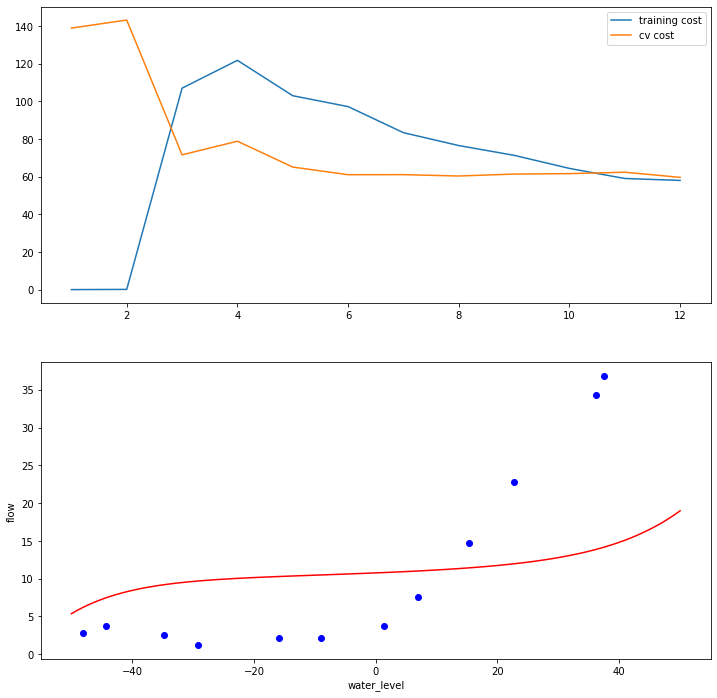

In [37]:
plot_learning_curve(X_ploy, X, y, Xval_ploy, yval, l=100)
plt.show()

正则化惩罚太大，变成 **欠拟合**状态

##  找到最佳的λ
通过之前的实验，我们可以发现$\lambda$可以极大程度地影响正则化多项式回归。
所以这部分我们会会使用验证集去评价$\lambda$的表现好坏，然后选择表现最好的$\lambda$后，用测试集测试模型在没有出现过的数据上会表现多好。
尝试$\lambda$值[0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

In [38]:
l_candidate = [ 0 , 0.001 , 0.003 , 0.01 , 0.03 , 0.1 , 0.3 , 1 , 3 ,10 ]
training_cost , cv_cost =[] , []

In [39]:

for l in l_candidate:
    res = linear_regression_np(X_ploy , y , l)
    
    tc = cost(res.x , X_ploy , y)
    cv = cost(res.x , Xval_ploy , yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)


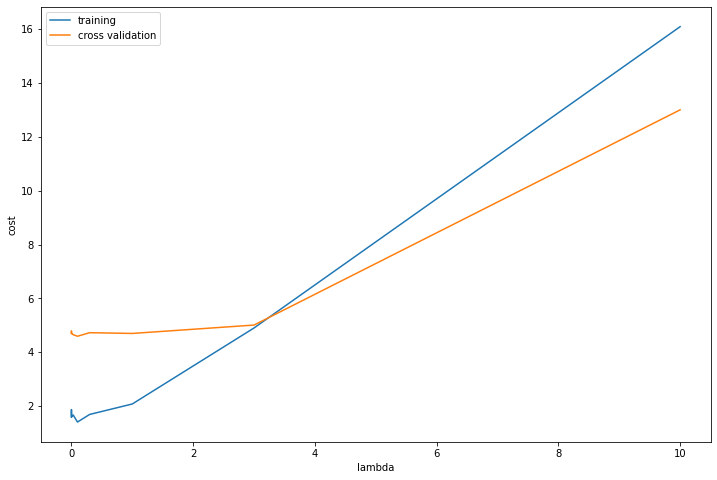

In [40]:
fig , ax = plt.subplots( figsize=(12,8) )
ax.plot(l_candidate , training_cost , label = 'training'  )
ax.plot(l_candidate , cv_cost , label = 'cross validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('cost')
plt.show()

In [41]:
l_candidate[np.argmin(cv_cost)]
# 找到最小交叉验证集对应的lambda

0.1

##  计算测试集上的误差
实际上，为了获得一个更好的模型，我们需要把最终的模型用在一个从来没有在计算中出现过的测试集上，也就是说，需要既没有被用作选择$\theta$，也没有被用作选择$\lambda$的数据

In [42]:
for l in l_candidate: 
    theta = linear_regression_np(X_ploy , y , l).x
    print('test cost (l={}) = {}'.format( l , cost(theta , Xtest_poly , ytest) ))
    

test cost (l=0) = 6.143651227946802
test cost (l=0.001) = 6.099437369975682
test cost (l=0.003) = 6.138225891497688
test cost (l=0.01) = 6.109144510071533
test cost (l=0.03) = 6.066064915003061
test cost (l=0.1) = 6.400751359538658
test cost (l=0.3) = 6.583083642792734
test cost (l=1) = 7.466289435179381
test cost (l=3) = 11.64556298193471
test cost (l=10) = 27.715070990266213
